# Perfectly balanced, as all things should be (Numerical Assignment)

Anthony Schøyen and Sondre Dahl

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
m = 1
a = 1
e = 1 ### epsilon
dt = 0.01

We shall consider the model:

\begin{equation}
    V(r_{ij}) = \varepsilon \left(  \left(  \frac{a}{r_{ij}}\right)^{12} - 2 \left(  \frac{a}{r_{ij}}\right)^{6}  \right)
\end{equation}

Using the generalized gateaux derivative and the chain rule, it can be shown that the partial derivative wrt $r_i$ is given by:

\begin{equation}
    \frac{\partial}{\partial \vec r_i} V(r_{ij}) = \frac{\vec r_i - \vec r_j}{r_{ij}} \frac{12 a^6 e (r_{ij}^6 - a^6)}{r_{ij}^{13}} = 12a^6 e \frac{(r_{ij}^6 - a^6)}{r_{ij}^{14}} (\vec r_i - \vec r_j)
\end{equation}

where $r_{ij} = |\vec r_i - \vec r_j|$

It is worth pointing out that if $r = a$  then $\partial_{r_i} V(r_{ij}) = 0 $. the distance $a$ will therefore be a sweet spot where the force is neither reuplsive or attractive. 

Furthermore, we will use the velocity Verlet algorithm, that is

\begin{align}
    \vec{r_i}(t + \Delta t) &= \vec{r_i}(t) + \vec{v_i} (t) \Delta t + \frac{\vec{f_i}(t)}{2 m} \Delta t^2 \\
    \vec{v_i}(t + \Delta t) &=\vec{v_i} (t) + \frac{\vec{f_i}(t) + \vec{f_i}(t+\Delta t)}{2 m} \Delta t
\end{align}

Where $f_i$ is given by 

\begin{equation}
    m \frac{d^2 \vec r_i}{dt^2} = f_i = - \sum_{j \neq i} \frac{\partial V (r_{ij})}{\partial r_i}
\end{equation}



With two particles, the forces will either face away or towards eachother. To make things easy, we will make it one dimensional. 

In [3]:
def Vi(r, a = 1, e = 1):
    return e * ( (a/r)**12 - 2 * (a/r)**6 )

def dVi(ri, rj, a = 1, e = 1):
    r = np.linalg.norm(ri - rj)
    return 12 * a**6 * e * (r**6 - a**6) * (ri - rj) / (r**14)

def fi(rmatrix, a = 1, e = 1, m = 1):
    n = len(rmatrix)
    f = np.zeros(np.shape(rmatrix))
    
    for i in range(n):
        fi = 0
        ri = rmatrix[i]
        for j in range(n):
            if i == j:
                continue
            fi -= dVi(ri, rmatrix[j] , a = 1, e = 1)
        f[i] = fi
    return f

The functions above are written in a vector friendly way. This will be important later. 

In [4]:
def Doubletrouble(r, dt, t, a = 1, e = 1, m = 1):
    r = np.array((0.0, 1.1)).T
    v = np.array((0.0, 0.0)).T
    
    n = int(t/dt)
    
    r_info = np.zeros((2, n))
    v_info = np.zeros((2, n))
    
    r_info[:, 0] = r ###Dette kan gi referanseproblemer
    v_info[:, 0] = v
    
    for i in range(n):
        fi1 = fi(r, a = 1, e = 1, m = 1)
        r += v * dt +(1/(2 * m)) * fi1 * dt**2
        fi2 = fi(r, a = 1, e = 1, m = 1)
        v += (fi1 + fi2)/(2 * m) * dt
        
        r_info[:, i] = r
        v_info[:, i] = v
        
    return r_info, v_info

Checking the results for some values of $dt$

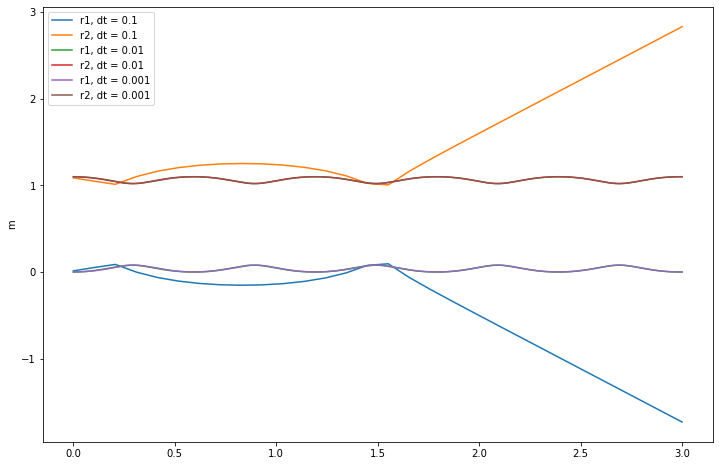

In [5]:
dt = [0.1, 0.01, 0.001]
tend = 3
plt.figure(figsize=(12, 8))
for i in range(len(dt)):
    r_info, v_info = Doubletrouble(1.1, dt[i], tend)
    t = np.linspace(0,tend, int(tend/dt[i]))
    plt.plot(t, r_info[0],'-',label='r1, dt = {}'.format(dt[i]))
    plt.plot(t, r_info[1],'-',label='r2, dt = {}'.format(dt[i]))
plt.ylabel('m')
plt.legend(fancybox = True)
plt.show()

For the two smaller values of $\Delta t$, we can clearly see an oscillating pattern. This makes sense as the lennard jones potential gives a force which has both a repulsive and an attractive term. When the particles are far apart, the attractiveness is dominant and vice versa. 

For a higher value of, e.g $\Delta t = 0.1$, the calculated path are much coarse. The forces are overestimated and the distance between the particles attain smaller and larger values than for $\Delta t = 0.01$. At some point, the repulsive force will overshoot and send the particles to their demise, floating apart for eternity. 

It is fair t assume that smaller values of $\Delta t$ gives a more accurate representation. For future values of $\Delta t$, we will assume $0.01$ to be sufficient. 

Checking if energy is presserves to check the validity of the simulation. 

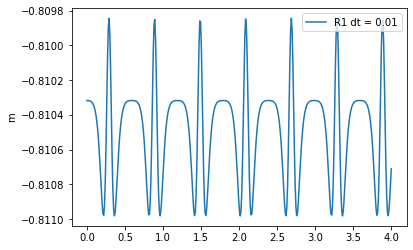

0.0014031450762227143


In [6]:
def E(r_info, v_info, a = 1, e = 1, m = 1): ### this function only allows 2 particles
    r = abs(r_info[0] - r_info[1])
    K = 1/2 * m *sum(v_info**2)
    P = Vi(r, a = 1, e = 1)
    return K + P

dt = 0.01
tend = 4
t = np.linspace(0,tend, int(tend/dt))


plt.figure()
r_info, v_info = Doubletrouble(1.1, dt, tend)
Energy = E(r_info, v_info)
plt.plot(t, E(r_info, v_info),'-',label='R1 dt = {}'.format(dt))
plt.ylabel('m')
plt.legend()
plt.show()

print(abs((np.amax(Energy) - np.amin(Energy))/np.mean(Energy)))

Though this graphs seems scary, the energy only fluctuate in a very small interval. We have printed $\frac{max - min}{mean}$ which gives an estimate on how small this interval actually is. The energy is approximately constant. 

**2)**

We'll start by making the desired grid and an random velocity vector.

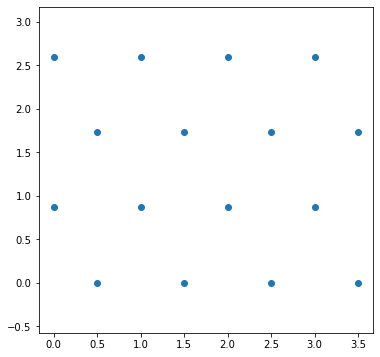

In [7]:
def Hex(a, d): ### Please only input square numbers for a
    N = int(np.sqrt(a))
    xv, yv = np.meshgrid(d * np.arange(N, dtype=float), d * np.arange(N))
    yv = yv * np.sqrt(3)/2
    xv[::2, :] += d/2
    
    return np.reshape(np.dstack((xv, yv)),(a,2))

def randomv(a, m):
    v = np.random.uniform(-1,1,(a,2)).T
    v /= np.apply_along_axis(np.linalg.norm, 0, v)
    return m * v.T

r = Hex(16,1)

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
ax.scatter(r[:,0], r[:,1])

In [8]:
def Ntroublehexagonal(N, dt, t, v0, a = 1, e = 1, m = 1): ### N square
    
    r = Hex(N, 1)
    v = randomv(N, v0)
    
    n = int(t/dt)
    
    r_info = np.zeros((N, 2, n))
    v_info = np.zeros((N, 2, n))
    
    r_info[:, :, 0] = r 
    v_info[:, :, 0] = v
    
    for i in range(1, n):
        fi1 = fi(r, a = 1, e = 1, m = 1)
        r += v * dt +(1/(2 * m)) * fi1 * dt**2
        fi2 = fi(r, a = 1, e = 1, m = 1)
        v += (fi1 + fi2)/(2 * m) * dt
        
        r_info[:, :, i] = r
        v_info[:, :, i] = v
        
    return r_info, v_info, np.linspace(0,t,n)

def plot_start_end(r_info, v): 
    fig, ((ax1,ax2)) = plt.subplots(1,2)
    fig.set_figheight(6)
    fig.set_figwidth(12)
    fig.suptitle("v = {}".format(v))
    
    ax1.axis('equal')
    ax1.title.set_text('Start')
    ax1.scatter(r_info[:,:,0][:,0], r_info[:,:,0][:,1])
    
    ax2.axis('equal')
    ax2.title.set_text('End')
    ax2.scatter(r_info[:,:,-1][:,0], r_info[:,:,-1][:,1])

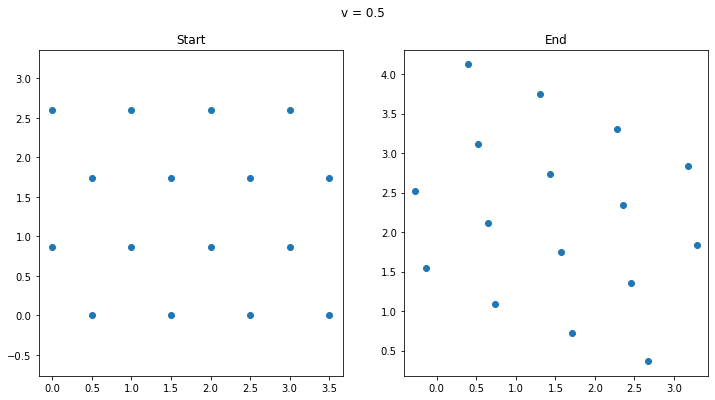

In [9]:
r_info, v_info, t_info = Ntroublehexagonal(16, 0.01, 5, 0.5)

plot_start_end(r_info, 0.5)

Here one can see how the crystal structure is presserved quite good. This makes sense as the potential force yields a sweet spot with distance $1$ from eachother. If any particle would deviate from the structure, every other particle will counteract it, putting it back to place. In some sense, the particles are keeping eachother in check, presserving the structure. 

We have seen however, that the grid has rotated and moved a little bit. The grid will be moving as an unit. 

Let's investigate two neighboring particles, say the two left nethermost particles.

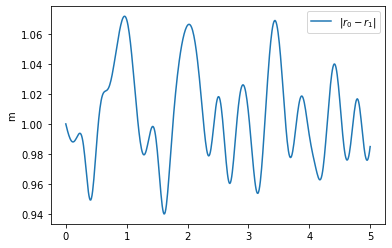

In [10]:
r = np.apply_along_axis(np.linalg.norm, 0, r_info[0] - r_info[1])

plt.figure()
plt.plot(t_info, r,'-',label = r'$|r_0 - r_1|$')
plt.ylabel('m')
plt.legend()
plt.show()

We saw in the case of $2$ particles that there were oscilations. That is also the case now, but alot less harmonic. They doesn't seem to have a periodic pattern, atleast for this time frame.

In [11]:
def ThePCKiller(r_info, v_info, m = 1):
    n = len(r_info[0,0])
    l = len(r_info)
    r = np.zeros((l,l), dtype = float)
    P = np.zeros((n), dtype = float)
    K = np.zeros((n), dtype = float)
    for k in range(n):
        for i in range(l):
            for j in range(i):
                r[i,j] = np.linalg.norm((r_info[i] - r_info[j])[:,k])
        P[k] = np.sum(np.nan_to_num(Vi(r)))
        K[k] = (1/2) * m * np.sum(v_info[:,:,k]**2)
    return P, K

**TL;DR Ignore the RuntimeWarnings!**

We will abuse the fact that "nan" exists. When we are storing the potential energy values we are using a matrix, which ends up being lower triangular. All the 0's in the upper corner have no contribution, but we can't really set them to anything. So we will just run them through the potential function, effectivly dividing by zero, then turning them back to zero.

C:\Users\Antho\AppData\Local\Temp/ipykernel_53908/2706585159.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return e * ( (a/r)**12 - 2 * (a/r)**6 )
C:\Users\Antho\AppData\Local\Temp/ipykernel_53908/2706585159.py:2: RuntimeWarning: invalid value encountered in subtract
  return e * ( (a/r)**12 - 2 * (a/r)**6 )


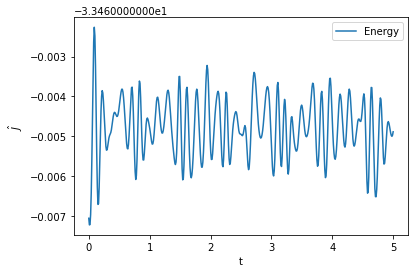

0.0014031450762227143


In [12]:
P, K = ThePCKiller(r_info, v_info)
E = P + K

plt.figure()
plt.plot(t_info, E,'-',label = 'Energy')
plt.ylabel(r'$\hat{J}$')
plt.xlabel('t')
plt.legend()
plt.show()

print(abs((np.amax(Energy) - np.amin(Energy))/np.mean(Energy)))

Again the energy is presserved. It fluctuates but it is negligible compared to its mean value. This is an indication for a good model. 

**2b)**

Since we are "comfortable", and don't use grass mowers when programming, we will be using $N = 49$

In [13]:
N = 49
r_info, v_info, t_info = Ntroublehexagonal(N, 0.01, 25, 0.01)

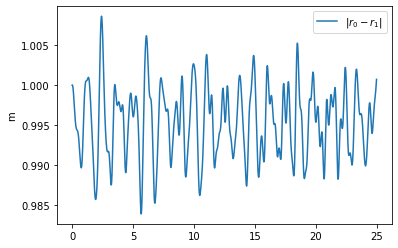

In [14]:
r = np.apply_along_axis(np.linalg.norm, 0, r_info[0] - r_info[1])

plt.figure()
plt.plot(t_info, r,'-',label = r'$|r_0 - r_1|$')
plt.ylabel('m')
plt.legend()
plt.show()

C:\Users\Antho\AppData\Local\Temp/ipykernel_53908/2706585159.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return e * ( (a/r)**12 - 2 * (a/r)**6 )
C:\Users\Antho\AppData\Local\Temp/ipykernel_53908/2706585159.py:2: RuntimeWarning: invalid value encountered in subtract
  return e * ( (a/r)**12 - 2 * (a/r)**6 )


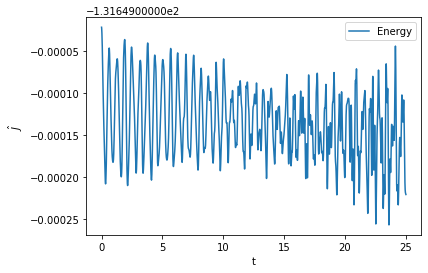

0.0014031450762227143


In [15]:
P, K = ThePCKiller(r_info, v_info)
E = P + K

plt.figure()
plt.plot(t_info, E,'-',label = 'Energy')
plt.ylabel(r'$\hat{J}$')
plt.xlabel('t')
plt.legend()
plt.show()

print(abs((np.amax(Energy) - np.amin(Energy))/np.mean(Energy)))

Which is essentially the same we got in the previous exercise, as expected.

**2c)**

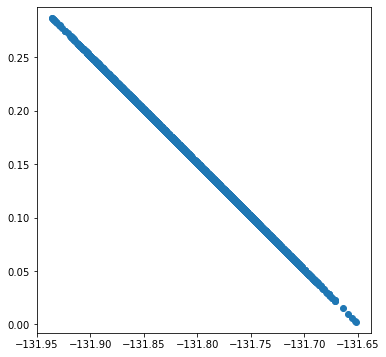

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
ax.scatter(P, K)

Which is linear. This is no shock. It makes sense as energy ($E = P + K$) is constant. Necessarily will $K(P) = E - P$ which should be linear. 

**2d)**

(array([ 16., 101., 213., 423., 519., 529., 353., 247.,  63.,  36.]),
 array([-0.01735719, -0.01420618, -0.01105517, -0.00790416, -0.00475315,
        -0.00160214,  0.00154886,  0.00469987,  0.00785088,  0.01100189,
         0.0141529 ]),
 <BarContainer object of 10 artists>)

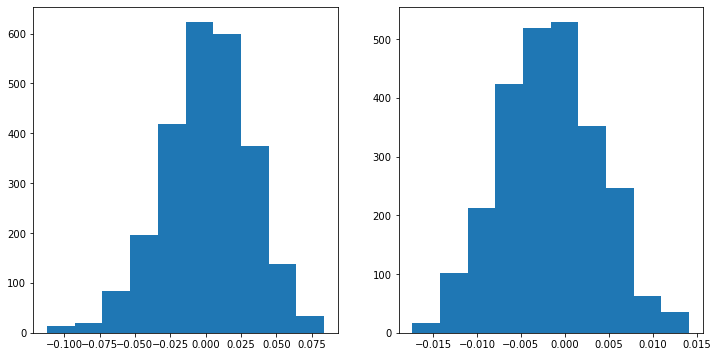

In [17]:
i = 25

fig, ((ax1,ax2)) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)  
ax1.hist(v_info[i,0])
ax2.hist(v_info[i,1])

We have picked particle in the middle of the grid as this is the particles most exposed to the crystal structure. 

I would say that these represent a gaussian function quite well. This is analogous to what the Maxwell-Boltzmann predict the distribution for each component should be. 

The following plot showcases the shape of the Maxwell-Boltzmann distribution, without any scaling. We can clearly see the resemblance.

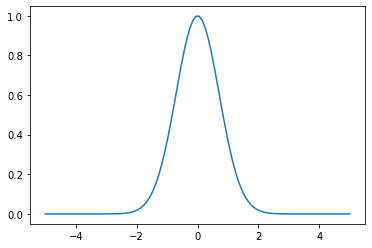

In [18]:
def f(x):
    return np.exp(-x**2)

t = np.linspace(-5,5,100)

plt.figure()
plt.plot(t,f(t))
plt.show()

**2e)**

C:\Users\Antho\AppData\Local\Temp/ipykernel_53908/2706585159.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return e * ( (a/r)**12 - 2 * (a/r)**6 )
C:\Users\Antho\AppData\Local\Temp/ipykernel_53908/2706585159.py:2: RuntimeWarning: invalid value encountered in subtract
  return e * ( (a/r)**12 - 2 * (a/r)**6 )


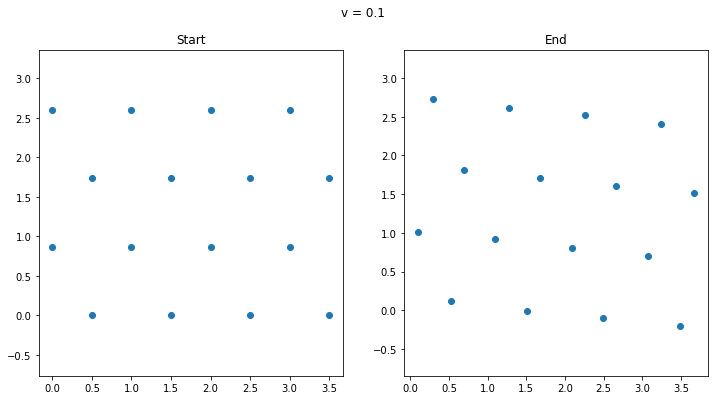

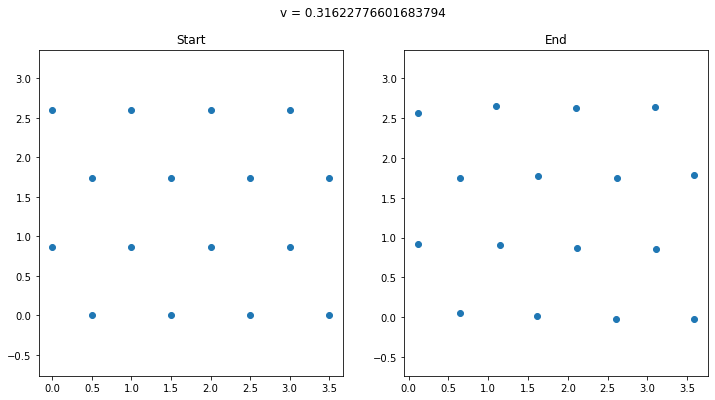

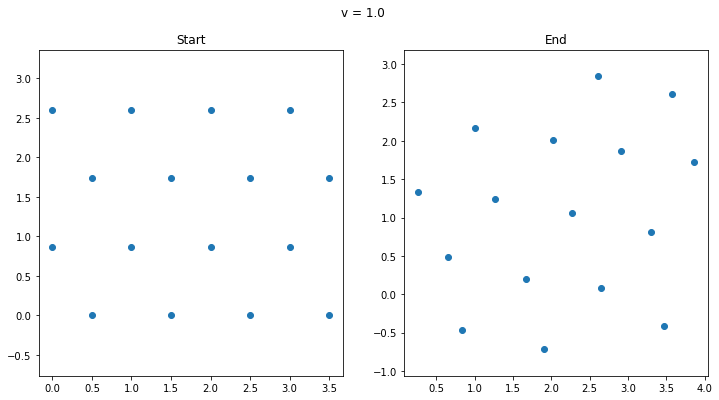

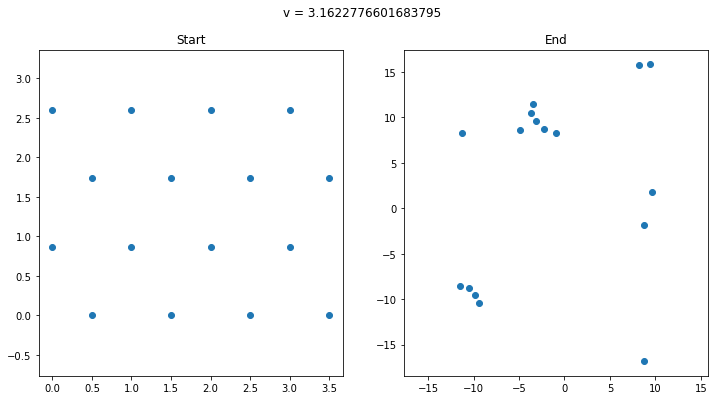

In [20]:
Vlist = [10**(i/2) for i in range(-2, 2)]

n = len(Vlist)
smallPP = np.empty(n)
bigKK = np.empty(n)

for i in range(n):
    r_info, v_info, t_info = Ntroublehexagonal(16, 0.01, 5, Vlist[i])
    P, K = ThePCKiller(r_info, v_info)
    smallPP[i] = np.mean(P)
    bigKK[i] = np.mean(K)
    plot_start_end(r_info, Vlist[i])

When the moduli of the $v_i$ are $10^{-1}$ or $10^{-\frac{1}{2}}$, the grid structure is presserved. However, the end position varies. We can see that the higher value moves the entire grid further away. Since the grid moves as a single unit, and the average velocity will be higher when moduli is higher, the grid will, on average, move faster. This trend holds in general, the "average position" is further away for higher moduli. 

For $|v_i| = 1$ we see a more liquid state. The particles moves more freely as they are not in a square. However the hexagonal structure is clearly pressent. 

$|v_i| = 10^{\frac{1}{2}}$ represents a gas. There is no continous structure. There are however some small colonies with a tight structure but the substance have broken into smaller parts.

This behavior makes sense. Temperature is just a distrubution of kinetical energy. Since energy is presserved, a high initial velocity represents a high temperature. Gas/liquid properties for higher temperatures is expected. 